In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pairwise_significance_exp_ids

query = {'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
         'expansions__vectors__dimensionality': 100,
         'expansions__vectors__rep': 0,
         'expansions__vectors__unlabelled': 'turian'}

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
ids = Experiment.objects.filter(**query).values_list('id', flat=True)
print('ids are', ids)
df = dataframe_from_exp_ids(ids, {'Algorithm':'expansions__vectors__algorithm', 
                                  'Composer':'expansions__vectors__composer',
                                  'Features': 'document_features_tr'})


ids are [38, 39, 40, 41, 42]
Features has 2500 values
Accuracy has 2500 values
folds has 2500 values
Composer has 2500 values
Algorithm has 2500 values


In [3]:
ids = list(ids.values_list('id', flat=True))
for eid in ids + [1]:
    exp = Experiment.objects.get(id=eid)
    mean, low, high, _ = get_ci(eid)
    print('%s & %.2f$\pm$%.2f \\\\'%(exp.expansions.vectors.composer, mean, (high-low)/2))

Add & 0.24$\pm$0.01 \\
Mult & 0.24$\pm$0.01 \\
Left & 0.23$\pm$0.01 \\
Right & 0.21$\pm$0.01 \\
Socher & 0.24$\pm$0.01 \\
random_neigh & 0.22$\pm$0.01 \\


In [4]:
pairwise_significance_exp_ids(zip(ids, [1]*len(ids)), name_format=['expansions__vectors__composer'])

Running significance for (38, 1)
Running significance for (39, 1)
Running significance for (40, 1)
Running significance for (41, 1)
Running significance for (42, 1)


,name1,acc1,name2,acc2,mean_diff,pval,significant
0,Add,0.240961,RandN,0.217762,0.023199,0.000,True
1,Mult,0.238723,RandN,0.217762,0.020960,0.000,True
2,Left,0.229133,RandN,0.217762,0.011370,0.044,False
3,Right,0.213364,RandN,0.217762,0.004398,0.504,False
4,Socher,0.235399,RandN,0.217762,0.017637,0.000,True


In [5]:
df.head()

,Accuracy,Algorithm,Composer,Features,folds
0,0.228024,turian,Add,J+N+AN+NN,0
1,0.228832,turian,Add,J+N+AN+NN,1
2,0.229063,turian,Add,J+N+AN+NN,2
3,0.229294,turian,Add,J+N+AN+NN,3
4,0.229641,turian,Add,J+N+AN+NN,4


In [6]:
def f1(x):
    return '%1.2f' % x

# ddf = df.drop('folds', axis=1).groupby(['Composer', 'k']).agg([np.mean, np.std])
# ddf.columns = ddf.columns.droplevel(0)#.reset_index()
# ddf['Accuracy'] = ddf['mean'].map(f1) + "$\pm$" + ddf['std'].map(f1)
# ddf = ddf.drop(['mean', 'std'], axis=1).reset_index()
# print(ddf.pivot_table(values='Accuracy', index='k', 
#                       columns='Composer', aggfunc=lambda x: x).to_latex(escape=False))

ddf = df.drop(['folds', 'Algorithm'], axis=1).groupby(['Composer', 'Features']).agg('mean').reset_index() # no need to drop unwanted columns
res = ddf.pivot_table(values='Accuracy', index='Composer', columns='Features')
print(res.to_latex(float_format=f1, na_rep='N/A'))
res.T

\begin{tabular}{lr}
\toprule
Features &  J+N+AN+NN \\
\midrule
Composer &            \\
Add      &       0.24 \\
Left     &       0.23 \\
Mult     &       0.24 \\
Right    &       0.21 \\
Socher   &       0.24 \\
\bottomrule
\end{tabular}



Composer,Add,Left,Mult,Right,Socher
Features,,,,,
J+N+AN+NN,0.241018,0.229331,0.238747,0.213341,0.235099


In [7]:
del res.index.name
del res.columns.name
for c in res.columns:
    print(res[[c]].to_latex(float_format=f1, na_rep='N/A'))
res[[c]]

\begin{tabular}{lr}
\toprule
{} &  J+N+AN+NN \\
\midrule
Add    &       0.24 \\
Left   &       0.23 \\
Mult   &       0.24 \\
Right  &       0.21 \\
Socher &       0.24 \\
\bottomrule
\end{tabular}



,J+N+AN+NN
Add,0.241018
Left,0.229331
Mult,0.238747
Right,0.213341
Socher,0.235099


# Compare to word2vec qualitatively 

In [8]:
from discoutils.thesaurus_loader import Vectors
from discoutils.tokens import DocumentFeature

In [9]:
v1 = Vectors.from_tsv('../FeatureExtractionToolkit/socher_vectors/turian_unigrams.h5')
v1.init_sims(n_neighbors=25)

In [10]:
v2 = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0')
v2.init_sims(n_neighbors=25)

In [11]:

def compare_neighbours(vectors, names, words=[], n_neighbours=5):
    if not words:
        words = random.sample([x for x in vectors[0].keys() if not x.count('_')], 10)
    words_clean = [DocumentFeature.from_string(w).tokens[0].text for w in words]
    data = []
    for w, w_clearn in zip(words, words_clean):
        this_row = []
        for v in vectors:
            neigh = v.get_nearest_neighbours(w)
            # remove neigh with the same PoS (for turian)
            new_neigh = []
            for n, _ in neigh:
                n1 = DocumentFeature.from_string(n).tokens[0].text
#                 print(n, n1)
                if n1 not in new_neigh:
                    if n1 != w_clearn:
                        new_neigh.append(n1)
#             print(new_neigh)
            if neigh:
                this_row.append(', '.join(n for n in new_neigh[:n_neighbours]))
            else:
                this_row.append(None)
        data.append(this_row)
    return pd.DataFrame(data, index=words_clean, columns=names)

In [12]:
# bunch of random words contained in both
words = 'andrade/N giant/J seize/V fundamental/J affidavit/N claim/V sikh/N rest/V israel/N arrow/N preventative/J torrential/J'.split()
df = compare_neighbours([v1, v2], ['turian', 'w2v'], words, n_neighbours=5)
df.to_csv('turian_vs_w2v.csv')
df

,turian,w2v
andrade,"aslam, rahman, aguirre, weinstein, chandra","souza, camilo, vives, leopoldo, barros"
giant,"monopoly, retailer, group, utility, unit","gigantic, legless, man-eating, serpentine, horned"
seize,"dissolve, renew, suppress, restore, donate","capture, re-take, attack, demoralise, crush"
fundamental,"inflationary, external, structural, speculativ...","principle, epistemic, objective, indeterminism..."
affidavit,"organization, affair, squad, essay, audience","testimony, al-arian, subpoena, demjanjuk, minkow"
claim,"request, link, plan, challenge, drive","allege, assert, believe, suggest, acknowledge"
sikh,"gambian, tutsi, bugging, zairean, rioting","sikhs, hindus, shi'ite, hindu, shiite"
rest,"size, duration, bottom, end, depth","dais, keep, gorge, gibbet, parihaka"
israel,"beijing, washington, bonn, pakistan, russia","iran, palestine, al-sadr, gush, salafi"
arrow,"atlantic, mississippi, mall, iberian, caribbean","bullet, quiver, gauntlet, upturned, sword"


In [13]:
print(pd.DataFrame(df.turian).to_latex())

\begin{tabular}{ll}
\toprule
{} &                                             turian \\
\midrule
andrade      &         aslam, rahman, aguirre, weinstein, chandra \\
giant        &           monopoly, retailer, group, utility, unit \\
seize        &         dissolve, renew, suppress, restore, donate \\
fundamental  &  inflationary, external, structural, speculativ... \\
affidavit    &       organization, affair, squad, essay, audience \\
claim        &              request, link, plan, challenge, drive \\
sikh         &          gambian, tutsi, bugging, zairean, rioting \\
rest         &                 size, duration, bottom, end, depth \\
israel       &        beijing, washington, bonn, pakistan, russia \\
arrow        &    atlantic, mississippi, mall, iberian, caribbean \\
preventative &  periodic, disgrace, compensatory, conclusive, ... \\
torrential   &  intermittent, severe, persistent, gusty, planting \\
\bottomrule
\end{tabular}



In [14]:
print(pd.DataFrame(df['w2v']).to_latex())

\begin{tabular}{ll}
\toprule
{} &                                                w2v \\
\midrule
andrade      &             souza, camilo, vives, leopoldo, barros \\
giant        &  gigantic, legless, man-eating, serpentine, horned \\
seize        &        capture, re-take, attack, demoralise, crush \\
fundamental  &  principle, epistemic, objective, indeterminism... \\
affidavit    &   testimony, al-arian, subpoena, demjanjuk, minkow \\
claim        &      allege, assert, believe, suggest, acknowledge \\
sikh         &              sikhs, hindus, shi'ite, hindu, shiite \\
rest         &                dais, keep, gorge, gibbet, parihaka \\
israel       &             iran, palestine, al-sadr, gush, salafi \\
arrow        &          bullet, quiver, gauntlet, upturned, sword \\
preventative &  preventive, prophylactic, life-saving, high-ri... \\
torrential   &    downpour, monsoonal, rainstorm, freezing, sleet \\
\bottomrule
\end{tabular}



# How many words of each PoS type are there in turian's unigrams
Code below largely copied from `socher_vectors.py`

In [15]:
from scipy.io import loadmat
mat = loadmat('../FeatureExtractionToolkit/socher_vectors/vars.normalized.100.mat')
words = [w[0] for w in mat['words'].ravel()]

In [17]:
import nltk
from nltk import WordNetLemmatizer
import string
from collections import defaultdict

lmtzr = WordNetLemmatizer()
clean_to_dirty = defaultdict(list)  # canonical -> [non-canonical]
dirty_to_clean = dict()  # non-canonical -> canonical
to_keep = set()  # which non-canonical forms forms we will keep
#  todo this can be done based on frequency or something

for w in words:
    if set(w).intersection(set(string.punctuation).union(set('0123456789'))):
        # not a real word- contains digits or punctuation
        continue

    lemma = lmtzr.lemmatize(w.lower())
    clean_to_dirty[lemma].append(w)
    dirty_to_clean[w] = lemma

# decide which of possibly many non-canonical forms with the same lemma to keep
# prefer shorter and lowercased non-canonical forms
for lemma, dirty_list in clean_to_dirty.items():
    if len(dirty_list) > 1:
        best_lemma = min(dirty_list, key=lambda w: (len(w), not w.islower()))
    else:
        best_lemma = dirty_list[0]
    to_keep.add(best_lemma)

In [18]:
pos_tagged = [nltk.pos_tag([w]) for w in to_keep]

In [19]:
from collections import defaultdict
pos_coarsification_map = defaultdict(lambda: "UNK")
pos_coarsification_map.update({"JJ": "J",
                               "JJN": "J",
                               "JJS": "J",
                               "JJR": "J",

                               "VB": "V",
                               "VBD": "V",
                               "VBG": "V",
                               "VBN": "V",
                               "VBP": "V",
                               "VBZ": "V",

                               "NN": "N",
                               "NNS": "N",
                               "NNP": "N",
                               "NPS": "N",
                               "NP": "N",

                               "RB": "RB",
                               "RBR": "RB",
                               "RBS": "RB",

                               "DT": "DET",
                               "WDT": "DET",

                               "IN": "CONJ",
                               "CC": "CONJ",

                               "PRP": "PRON",
                               "PRP$": "PRON",
                               "WP": "PRON",
                               "WP$": "PRON",

                               ".": "PUNCT",
                               ":": "PUNCT",
                               ":": "PUNCT",
                               "": "PUNCT",
                               "'": "PUNCT",
                               "\"": "PUNCT",
                               "'": "PUNCT",
                               "-LRB-": "PUNCT",
                               "-RRB-": "PUNCT"})

In [20]:
pos_tags = [pos_coarsification_map[x[0][1]] for x in pos_tagged]

In [21]:
from collections import Counter
Counter(pos_tags)

Counter({'N': 23160, 'V': 5939, 'J': 2160, 'RB': 1082, 'CONJ': 421, 'PRON': 186, 'DET': 39, 'UNK': 27})

# Let's look at the embeddings 

In [60]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
sns.set_style('white')

def draw_tsne_embeddings(v):
    # pairs of words from Mikolov et al (2013)- Distributed word reprs and their compositionality
    # ignored some pairs that do not have a vectors
    words = 'china/N beijing/N russia/N moscow/N japan/N tokyo/N turkey/N ankara/N france/N \
            paris/N italy/N rome/N greece/N athens/N germany/N berlin/N portugal/N lisbon/N spain/N madrid/N'.split()
    mat = np.vstack([v.get_vector(w).A for w in words])
    reduced = TSNE(init='pca').fit_transform(normalize(mat))
#     ax = plt.fig
    plt.scatter(reduced[:, 0], reduced[:, 1]);

    # point labels
    for i, txt in enumerate(words):
        plt.annotate(txt, (reduced[i, 0], reduced[i, 1]), fontsize=20);

    # lines between country-capital pairs
    for i in range(len(words)):
        if i %2 != 0:
            continue
        plt.plot([reduced[i, 0], reduced[i+1, 0]],
                 [reduced[i, 1], reduced[i+1, 1]], alpha=0.5, color='black')
    
    # remove all junk from plot
    sns.despine(left=True, bottom=True)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

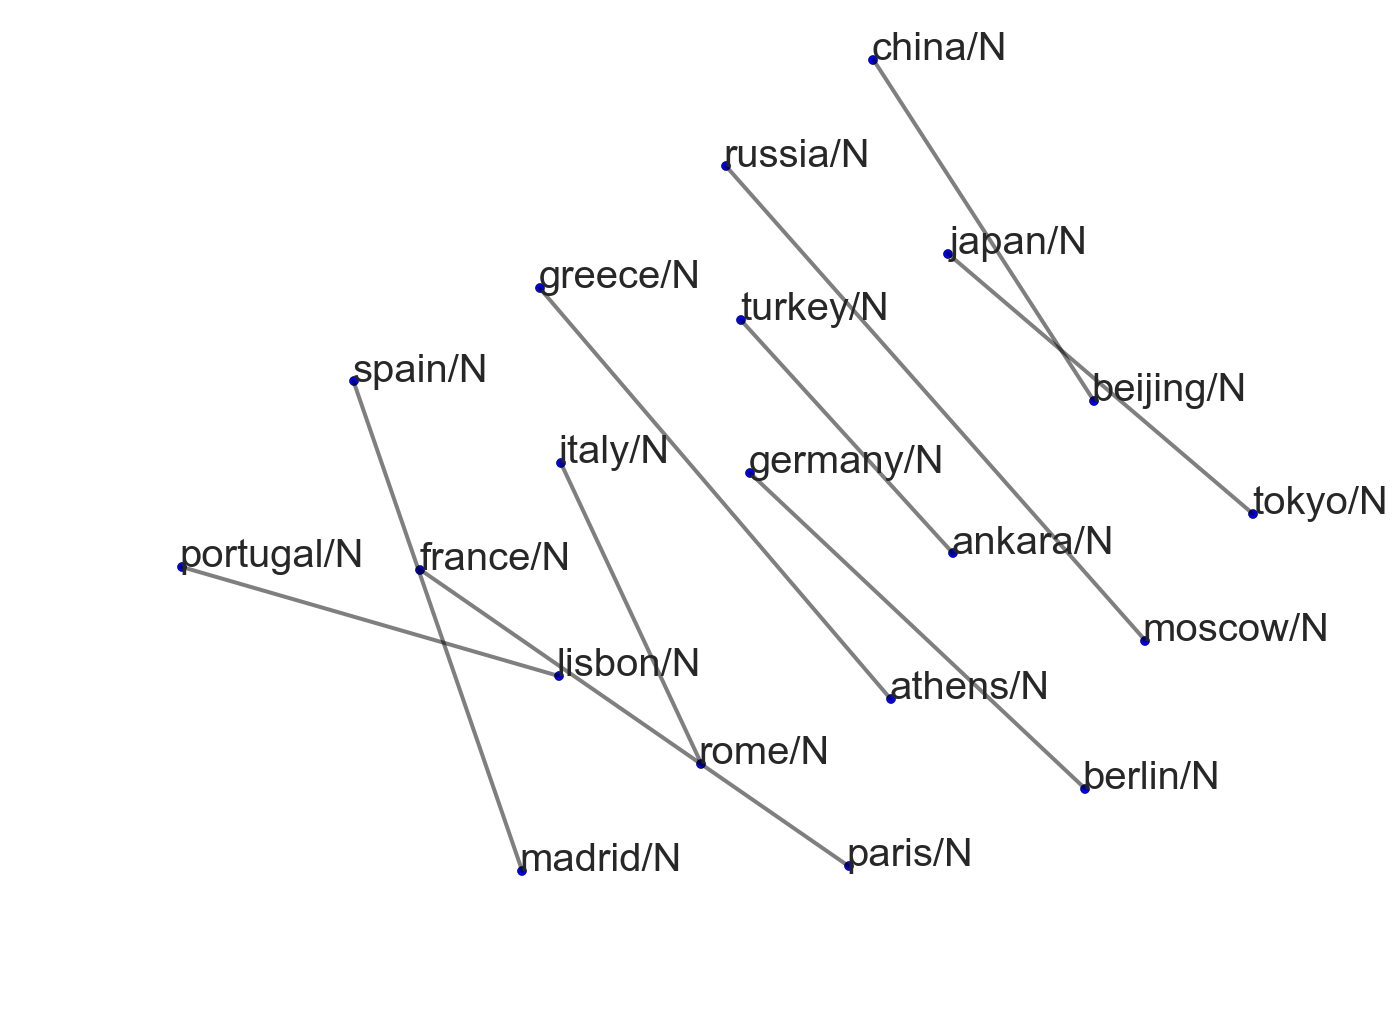

In [115]:
v = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0') # look very good 
draw_tsne_embeddings(v)
plt.savefig('plot-mikolov-tsne-w2v-wiki.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

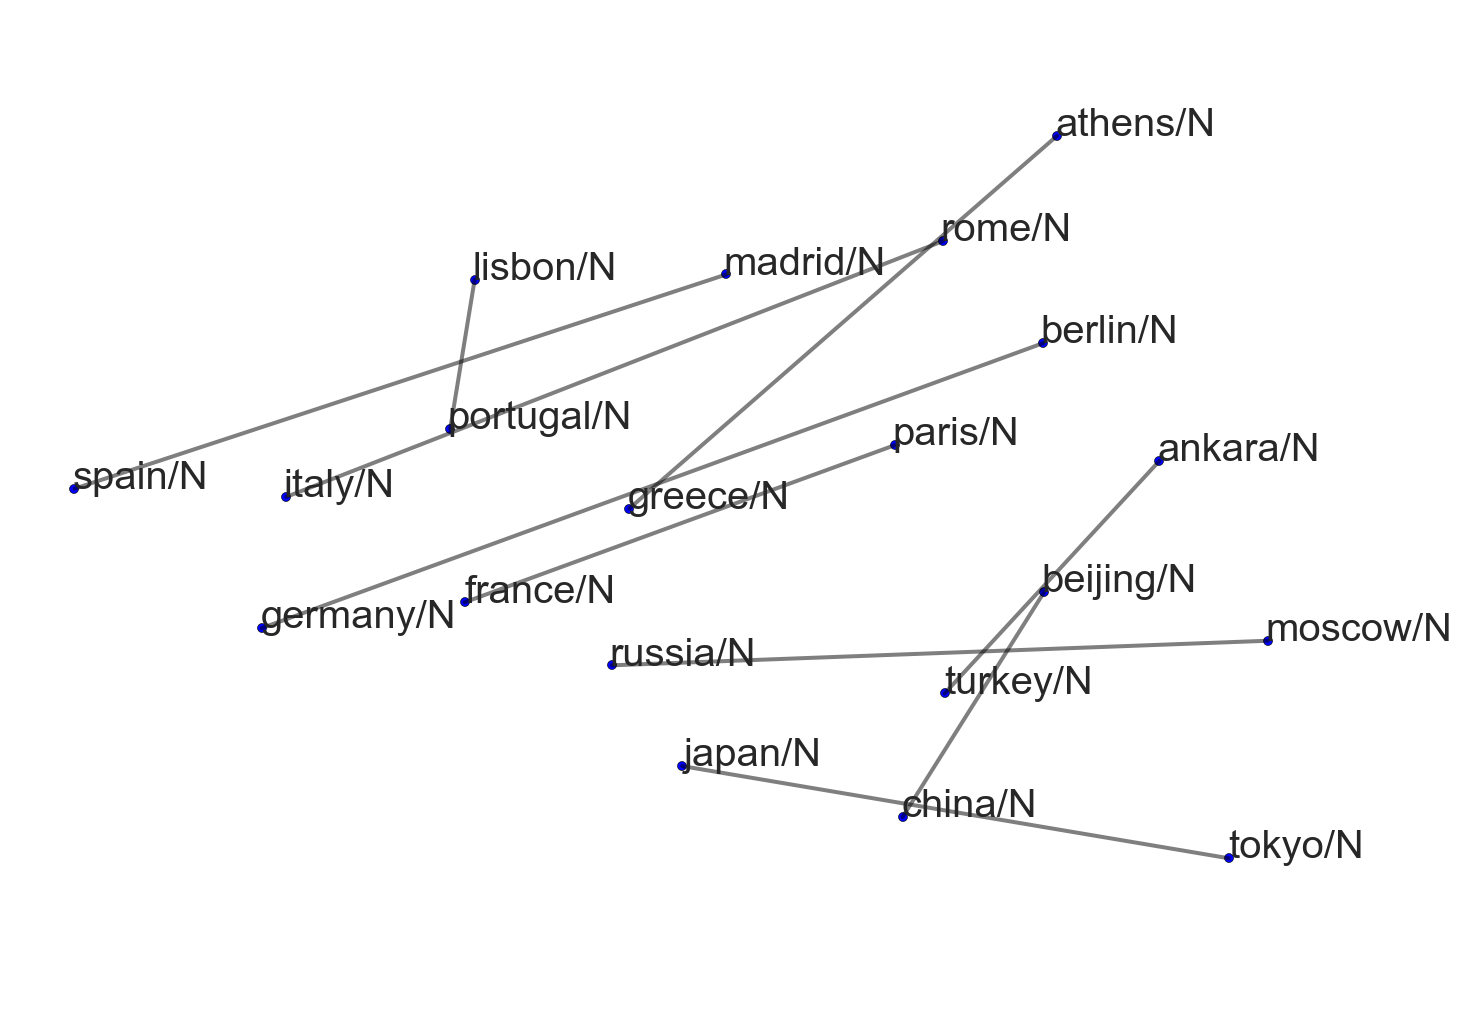

In [117]:
v = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/word2vec-gigaw-100perc.unigr.strings.rep0') # ok 
draw_tsne_embeddings(v)
plt.savefig('plot-mikolov-tsne-w2v-gigaw.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

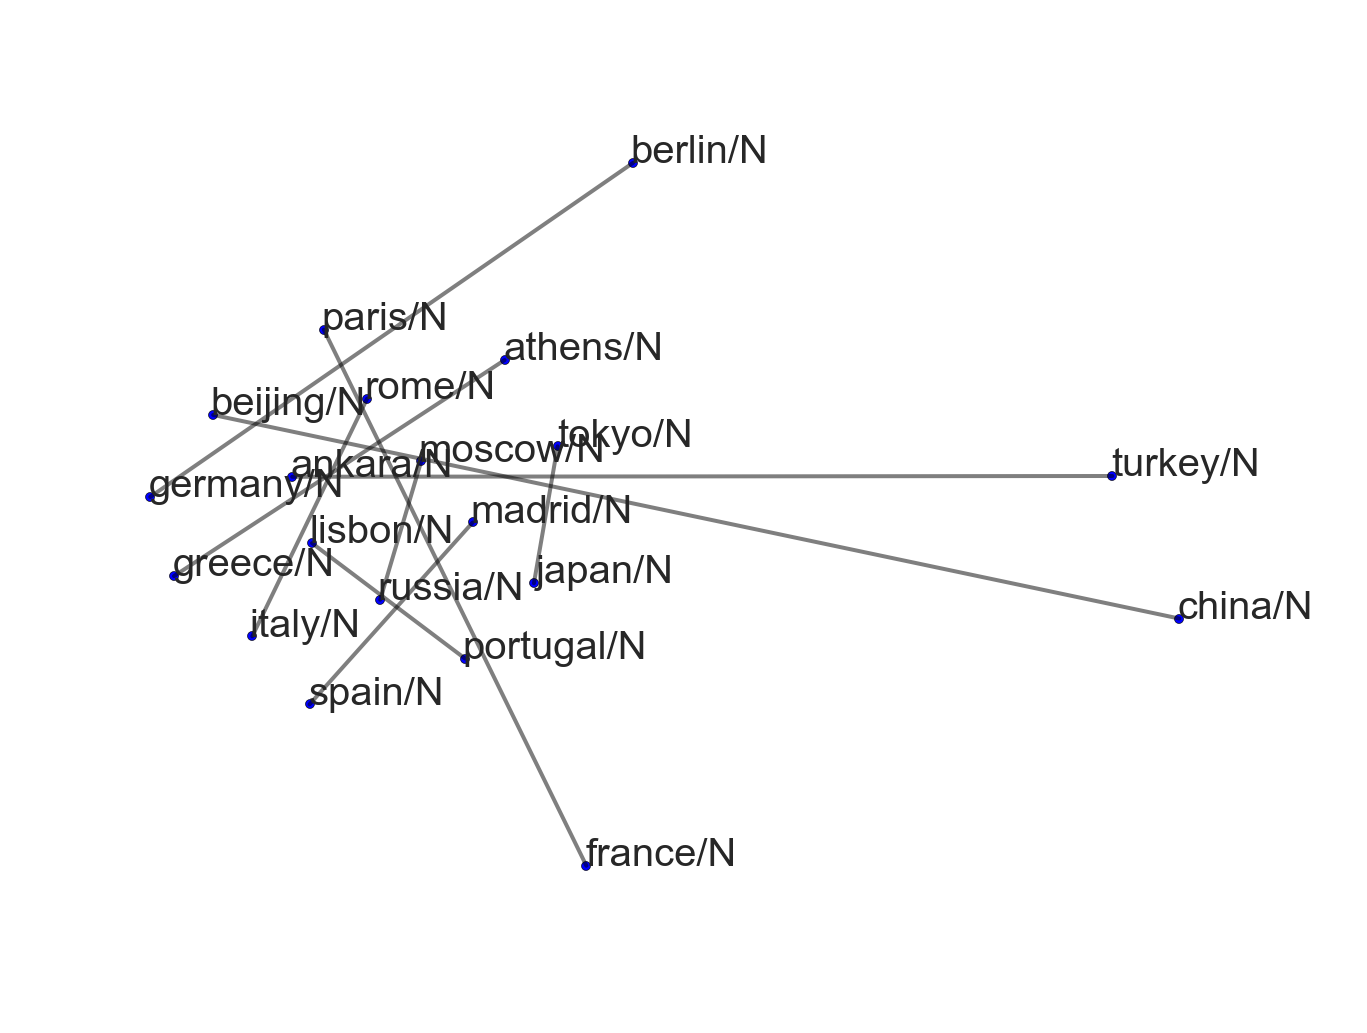

In [118]:
v = Vectors.from_tsv('../FeatureExtractionToolkit/socher_vectors/turian_unigrams.h5') # terrible
draw_tsne_embeddings(v)
plt.savefig('plot-mikolov-tsne-turian.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

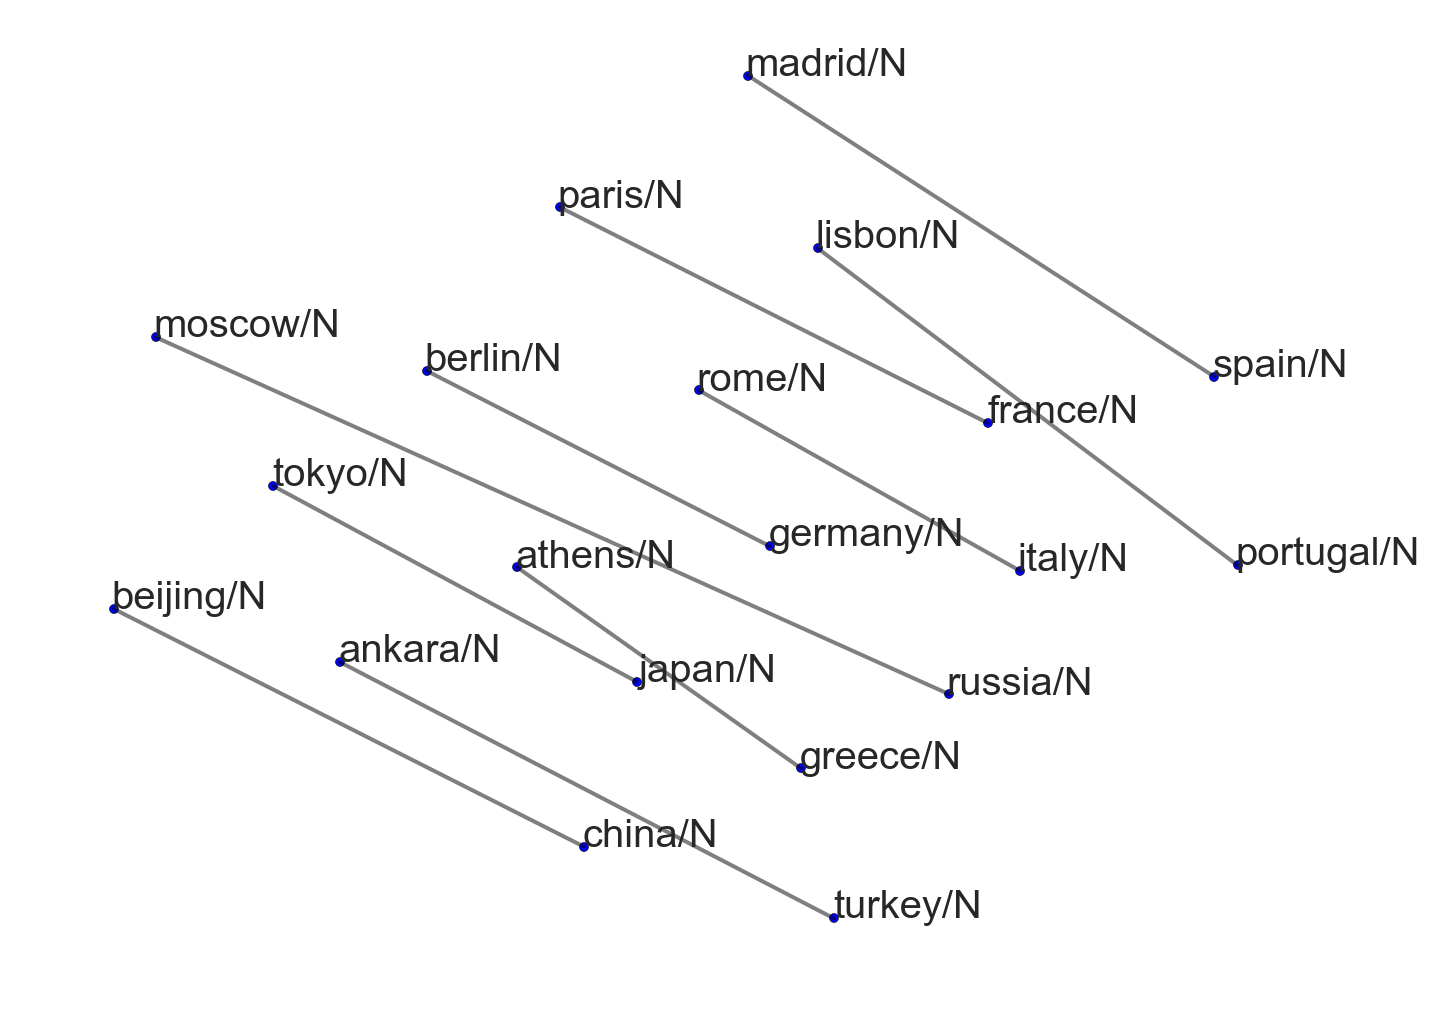

In [116]:
v = Vectors.from_tsv('../FeatureExtractionToolkit/glove/vectors.miro.h5') # terrible
draw_tsne_embeddings(v)
plt.savefig('plot-mikolov-tsne-glove-wiki.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)